In [ ]:
!pip install matplotlib

In [ ]:
import torch
from torchvision.datasets import CocoDetection
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
from torchvision.ops import box_iou

In [ ]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):

        coco = self.coco

        img_id = self.ids[index]

        ann_ids = coco.getAnnIds(imgIds=img_id)

        coco_annotation = coco.loadAnns(ann_ids)

        path = coco.loadImgs(img_id)[0]['file_name']

        img = Image.open(os.path.join(self.root, path))


        num_objs = len(coco_annotation)


        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        labels = torch.ones((num_objs,), dtype=torch.int64)

        img_id = torch.tensor([img_id])

        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)


        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

CONJUNTO - DADOS RIO

In [ ]:
root_folder = "/content/drive/MyDrive/Water Level Identification/River/Images River"
json_annotation_file = "/content/drive/MyDrive/Water Level Identification/River/detection/river-multi-detection.json"


transform = Compose([ToTensor()])

custom_dataset = myOwnDataset(root=root_folder, annotation=json_annotation_file, transforms=transform)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


CONJUNTO - DADOS PISCINA

In [ ]:
root_folder_pool = "/content/drive/MyDrive/Water Level Identification/Pool/Images Pool"
json_annotation_file_pool = "/content/drive/MyDrive/Water Level Identification/Pool/detection/pool_multi_detection.json"


transform = Compose([ToTensor()])

custom_dataset_pool = myOwnDataset(root=root_folder_pool, annotation=json_annotation_file_pool, transforms=transform)

loader_piscina = DataLoader(custom_dataset_pool, batch_size=8, shuffle=True, collate_fn = collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
tamanho_treino = int(0.8 * len(custom_dataset))
tamanho_teste = len(custom_dataset) - tamanho_treino


conjunto_treino, conjunto_teste = random_split(custom_dataset, [tamanho_treino, tamanho_teste])


loader_treino = DataLoader(conjunto_treino, batch_size=4, shuffle=True, collate_fn = collate_fn)
loader_teste = DataLoader(conjunto_teste, batch_size=4, shuffle=False, collate_fn = collate_fn)

In [ ]:
print(len(loader_treino))
print(len(loader_teste))

24
6


In [ ]:
print(len(loader_piscina))

27


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


for imgs, annotations in loader_teste:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)

In [ ]:
num_classes = 2

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# for param in model.parameters():
#     param.requires_grad = False


in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()


num_epochs = 5
len_dataloader = len(loader_treino)
print(len_dataloader)

all_losses = []

for epoch in range(num_epochs):
    total_iou = 0.0
    total_boxes = 0
    model.train()
    i = 0
    for imgs, annotations in loader_treino:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())
        all_losses.append(losses)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Epoch: {epoch+1}, Iteration: {i}/{len_dataloader}, Loss: {losses}')

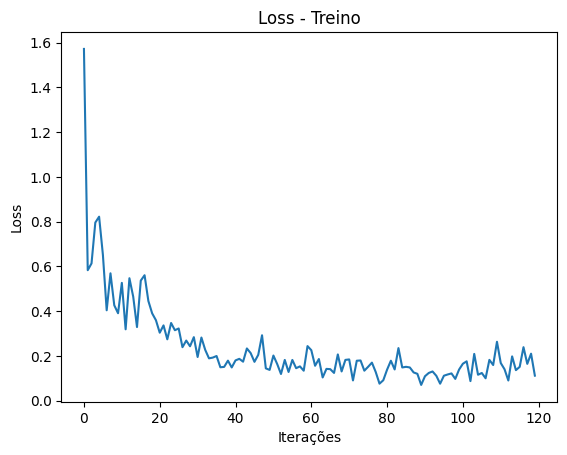

In [ ]:
for i,loss in enumerate(all_losses):
  all_losses[i] = loss.cpu().detach().numpy()

plt.plot(all_losses)
plt.xlabel('Iterações')
plt.ylabel('Loss')
plt.title('Loss - Treino')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

total_iou = 0.0
total_boxes = 0
accuracies = []

for imgs, annotations in loader_treino:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

    with torch.no_grad():
        model.eval()
        pred_annotations = model(imgs, annotations)

    for pred_boxes, true_boxes in zip(pred_annotations, annotations):
        pred_boxes = pred_boxes['boxes'].cpu().detach().numpy()
        true_boxes = true_boxes['boxes'].cpu().detach().numpy()

        for pred_box in pred_boxes:
            ious = box_iou(torch.from_numpy(pred_box.reshape(1, 4)), torch.from_numpy(true_boxes))
            max_iou = ious.max().item()
            total_iou += max_iou
            total_boxes += 1


        if len(pred_boxes) > 0:
            accuracies.append(max_iou)

average_iou = total_iou / total_boxes if total_boxes > 0 else 0.0
print(f'Média IoU TREINO (TREINADO E AVALIADO NO RIO): {average_iou}')


average_accuracy = sum(accuracies) / len(accuracies) if accuracies else 0.0
print(f'Acurácia média TREINO (TREINADO E AVALIADO NO RIO): {average_accuracy}')



Média IoU (TREINADO E AVALIADO NO RIO): 0.7325320917456835
Acurácia média (TREINADO E AVALIADO NO RIO): 0.39985436085175646


In [ ]:
import matplotlib.pyplot as plt

total_iou = 0.0
total_boxes = 0
accuracies = []

for imgs, annotations in loader_teste:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

    with torch.no_grad():
        model.eval()
        pred_annotations = model(imgs, annotations)

    for pred_boxes, true_boxes in zip(pred_annotations, annotations):
        pred_boxes = pred_boxes['boxes'].cpu().detach().numpy()
        true_boxes = true_boxes['boxes'].cpu().detach().numpy()

        for pred_box in pred_boxes:
            ious = box_iou(torch.from_numpy(pred_box.reshape(1, 4)), torch.from_numpy(true_boxes))
            max_iou = ious.max().item()
            total_iou += max_iou
            total_boxes += 1


        if len(pred_boxes) > 0:
            accuracies.append(max_iou)

average_iou = total_iou / total_boxes if total_boxes > 0 else 0.0
print(f'Média IoU TESTE (TREINADO E AVALIADO NO RIO): {average_iou}')


average_accuracy = sum(accuracies) / len(accuracies) if accuracies else 0.0
print(f'Acurácia média TESTE (TREINADO E AVALIADO NO RIO): {average_accuracy}')

Média IoU TESTE (TREINADO E AVALIADO NO RIO): 0.7226006422724043
Acurácia média TESTE (TREINADO E AVALIADO NO RIO): 0.33698878685633343


In [ ]:
import matplotlib.pyplot as plt

total_iou = 0.0
total_boxes = 0
accuracies = []

for imgs, annotations in loader_piscina:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

    with torch.no_grad():
        model.eval()
        pred_annotations = model(imgs, annotations)

    for pred_boxes, true_boxes in zip(pred_annotations, annotations):
        pred_boxes = pred_boxes['boxes'].cpu().detach().numpy()
        true_boxes = true_boxes['boxes'].cpu().detach().numpy()

        for pred_box in pred_boxes:
            ious = box_iou(torch.from_numpy(pred_box.reshape(1, 4)), torch.from_numpy(true_boxes))
            max_iou = ious.max().item()
            total_iou += max_iou
            total_boxes += 1


        if len(pred_boxes) > 0:
            accuracies.append(max_iou)

average_iou = total_iou / total_boxes if total_boxes > 0 else 0.0
print(f'Média IoU (TREINADO NO RIO E AVALIADO NA PISCINA): {average_iou}')


average_accuracy = sum(accuracies) / len(accuracies) if accuracies else 0.0
print(f'Acurácia média (TREINADO NO RIO E AVALIADO NA PISCINA): {average_accuracy}')

Média IoU (TREINADO NO RIO E AVALIADO NA PISCINA): 0.006512164121059785
Acurácia média (TREINADO NO RIO E AVALIADO NA PISCINA): 0.006880730886030667
